In [2]:
from setup   import *
from netCDF4 import Dataset
import glob
from joint_flight.results import *

(0, 10)

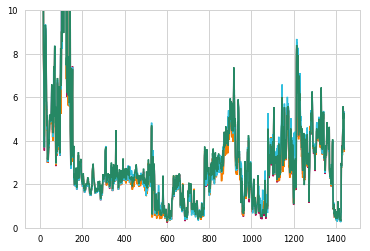

In [5]:
diagnostics_8ca = results["8_column_aggregate"]["diagnostics"]
diagnostics_lpa = results["large_plate_aggregate"]["diagnostics"]
diagnostics_lca = results["large_column_aggregate"]["diagnostics"]
diagnostics_cmbnd = results["combined"]["diagnostics"]
plt.plot(diagnostics_8ca[:, 2])
plt.plot(diagnostics_lpa[:, 2])
plt.plot(diagnostics_lca[:, 2])
plt.plot(diagnostics_cmbnd[:, 2])
plt.ylim([0, 10])

In [3]:
5 * 160

800

## Fitted observations

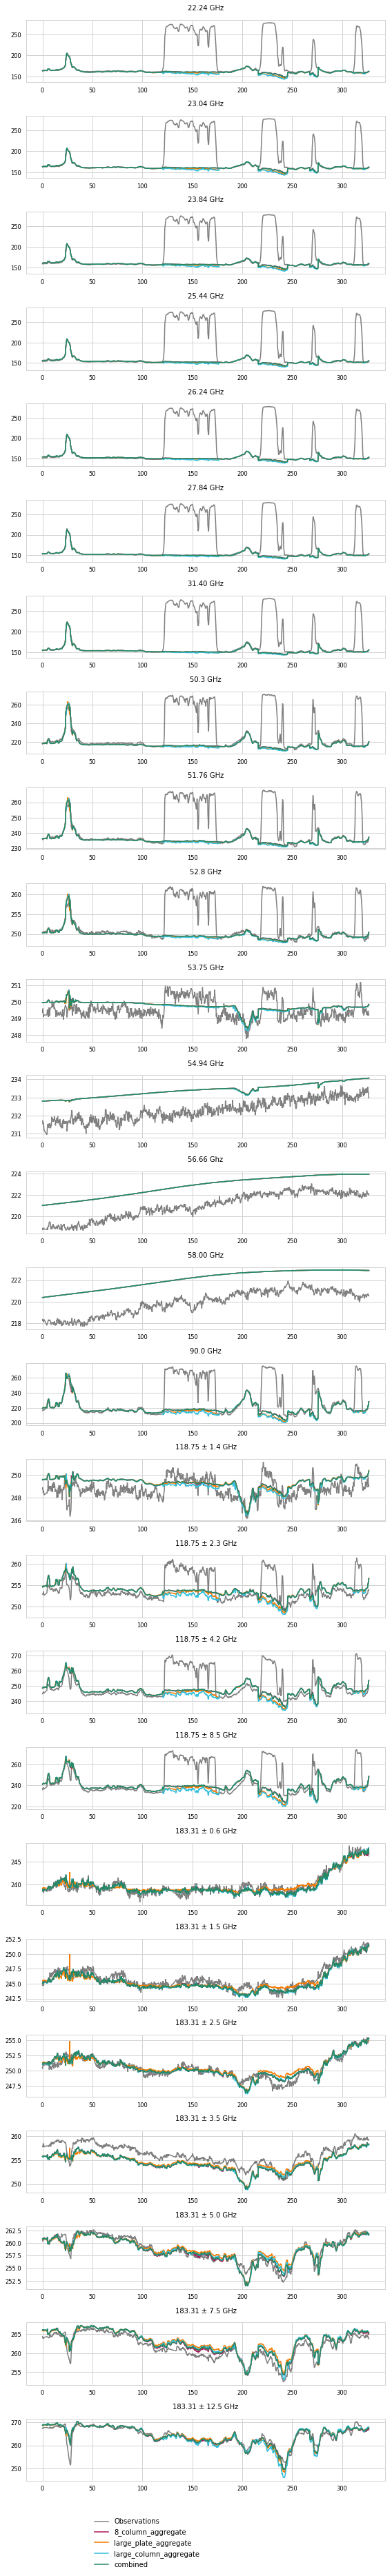

In [7]:
from joint_flight.data import hamp

n = 26
f, axs = plt.subplots(26, 1, figsize = (8,  2 * n))

channel_names_hamp = ["22.24 GHz", "23.04 GHz", "23.84 GHz", "25.44 GHz",   \
                      "26.24 GHz", "27.84 GHz", "31.40 GHz", "50.3 GHz", "51.76 GHz", \
                      "52.8 GHz", "53.75 GHz", "54.94 GHz", "56.66 Ghz", "58.00 GHz", \
                      "90.0 GHz"] + ["118.75 ± 8.5 GHz", "118.75 ± 4.2 GHz", "118.75 ± 2.3 GHz", \
                      "118.75 ± 1.4 GHz"][::-1]  \
                      + ["183.31 ± 12.5 GHz", "183.31 ± 7.5 GHz", "183.31 ± 5.0 GHz", \
                       "183.31 ± 3.5 GHz", "183.31 ± 2.5 GHz", "183.31 ± 1.5 GHz",  \
                       "183.31 ± 0.6 GHz"][::-1]

y = results["large_plate_aggregate"]["y_hamp_passive"]
mask = np.all(y < 1e9, axis = 1)
x = hamp.d[:-1][mask]

for i in range(n):
    ax = axs[i]
    ax.plot(x, y[mask, i], c = "gray", label = "Observations")
    
for shape in ["8_column_aggregate", "large_plate_aggregate", "large_column_aggregate", "combined"]:
    yf = results[shape]["yf_hamp_passive"]
    mask = np.all(yf < 1e9, axis = 1)
    x  = hamp.d[:-1][mask]
    for i in range(n):
        ax = axs[i]
        ax.set_title(channel_names_hamp[i])
        ax.plot(x, yf[mask, i], label = shape)
ax.legend(bbox_to_anchor = [0.5, -0.5])
plt.tight_layout()

f.savefig("../plots/retrieval_fits_hamp.pdf")

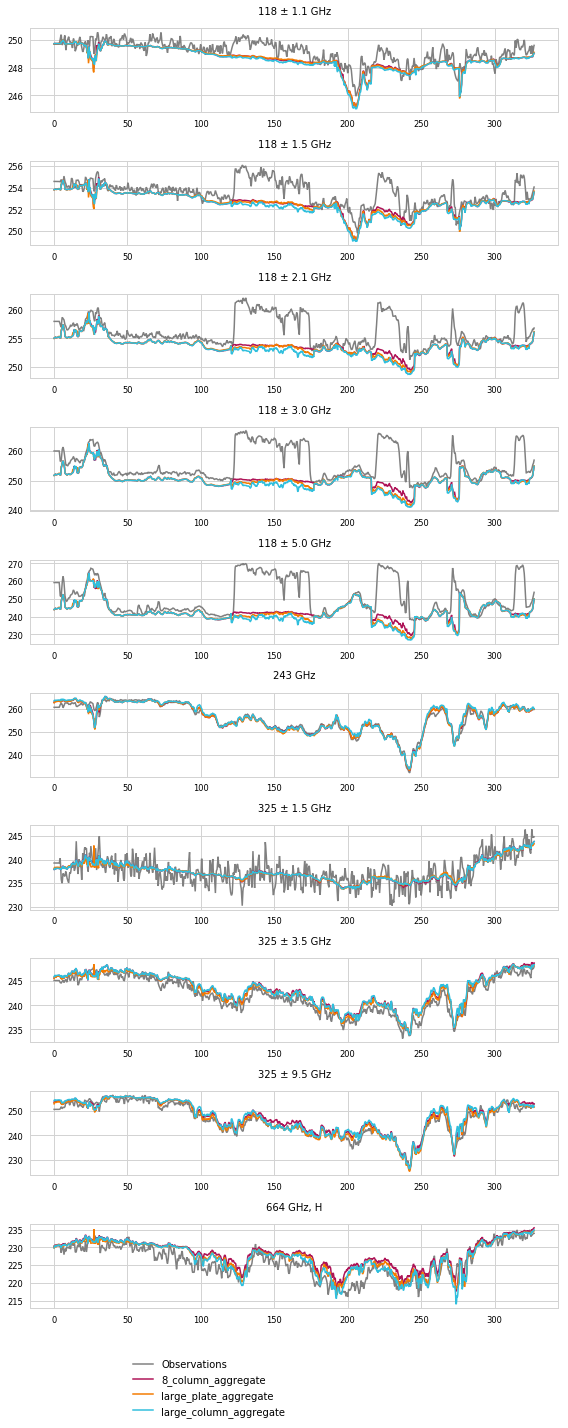

In [5]:
from joint_flight.data import hamp

n = 10
f, axs = plt.subplots(n, 1, figsize = (8,  2 * n))

channel_names_ismar = ["118 ± 1.1 GHz", "118 ± 1.5 GHz", "118 ± 2.1 GHz", "118 ± 3.0 GHz", "118 ± 5.0 GHz", \
                       "243 GHz", "325 ± 1.5 GHz", "325 ± 3.5 GHz", "325 ± 9.5 GHz", "664 GHz, H"]

y = results["large_plate_aggregate"]["y_ismar"]
mask = np.all(y < 1e9, axis = 1)
x = hamp.d[:-1][mask]

for i in range(n):
    ax = axs[i]
    ax.plot(x, y[mask, i], c = "gray", label = "Observations")
    
for shape in ["8_column_aggregate", "large_plate_aggregate", "large_column_aggregate"]:
    yf = results[shape]["yf_ismar"]
    mask = np.all(yf < 1e9, axis = 1)
    x  = hamp.d[:-1][mask]
    for i in range(n):
        ax = axs[i]
        ax.set_title(channel_names_ismar[i])
        ax.plot(x, yf[mask, i], label = shape)
ax.legend(bbox_to_anchor = [0.5, -0.5])

plt.tight_layout()
f.savefig("../plots/retrieval_fits_ismar.pdf")

## Retrieval residuals

In [9]:
import seaborn as sns
sns.reset_orig()

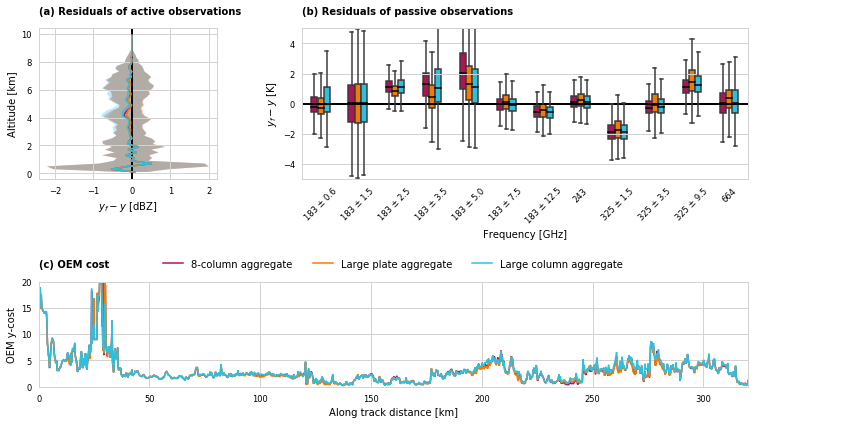

In [11]:
from matplotlib.gridspec import GridSpec
import pandas as pd

f = plt.figure(figsize = (12, 6))
gs = GridSpec(2, 3, width_ratios = [0.4, 1.0, 0.03], height_ratios = [0.7, 1.0][::-1])


#
# RADAR errors
#

ax = plt.subplot(gs[0, 0])
ax.axvline(0, lw = 2, c = "k")

for shape in ["8_column_aggregate", "large_plate_aggregate", "large_column_aggregate"]:
    y  = results[shape]["y_hamp_radar"]
    yf = results[shape]["yf_hamp_radar"]
    mask = np.all(yf < 1e9, axis = 1)
    dy = yf[mask, :] - y[mask, :]
    
    dy_mean  = np.mean(dy.data, axis = 0)
    dy_sigma = np.std(dy.data, axis = 0)

    y = np.linspace(0.1, 9.9, 50)
    ax.plot(dy_mean, y, label = shape)
    ax.fill_betweenx(y, dy_mean - dy_sigma, dy_mean + dy_sigma, alpha = 0.3)
    
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("$y_f - y$ [dBZ]")
ax.set_title("(a) Residuals of active observations", loc = "left", fontweight = "bold")
#
# Boxplot
#


ax = plt.subplot(gs[0, 1])

indices = [list(range(19, 26)), [5, 6, 7, 8, 9]]
frequencies = [["183 ± 0.6", "183 ± 1.5", "183 ± 2.5", "183 ± 3.5", "183 ± 5.0", "183 ± 7.5", "183 ± 12.5"], \
               ["243", "325 ± 1.5", "325 ± 3.5", "325 ± 9.5", "664"]]


dys = []
shapes = []
channels = []
for si, shape in enumerate(["8_column_aggregate", "large_plate_aggregate", "large_column_aggregate"]):
    
    yf = results[shape]["yf_hamp_passive"]
    y  = results[shape]["y_hamp_passive"]
    mask = np.all(y < 1e9, axis = 1)
    dy = yf[mask, :] - y[mask, :]
    for i in indices[0]:
        dys +=  [dy[:, i].ravel()]
        shapes += int(mask.sum()) * [shape]
        channels += int(mask.sum()) * [i]
        
    yf = results[shape]["yf_ismar"]
    y  = results[shape]["y_ismar"]
    mask = np.all(y < 1e9, axis = 1)
    dy = yf[mask, :] - y[mask, :]
    for i in indices[1]:
        dys += [dy[:, i].ravel()]
        shapes += int(mask.sum()) * [shape]
        channels += int(mask.sum()) * [i]
        
dys = np.concatenate(dys, axis = 0).ravel()
data = {"dy" : dys, "shape" : shapes, "channel" : channels}
data = pd.DataFrame(data)
        
ax.axhline(0, lw = 2, c = "k")
sns.boxplot(x = "channel", y = "dy", hue = "shape", data = data, showfliers = False, medianprops = {"color" : "k"}, saturation = 1, width = 0.5)
ax.get_legend().remove()
ax.set_ylim([-5, 5])
ax.set_ylabel("$y_f - y$ [K]")
ax.set_title("(b) Residuals of passive observations", loc = "left", fontweight = "bold")

labels = frequencies[0] + frequencies[1]
ax.set_xticklabels(labels, rotation = 45)
ax.set_xlabel("Frequency [GHz]")

#
# OEM error
#

ax = plt.subplot(gs[1, :2])

handles = []
names = ["8-column aggregate", "Large plate aggregate", "Large column aggregate"]
for i, shape in enumerate(["8_column_aggregate", "large_plate_aggregate", "large_column_aggregate"]):
    diagnostics = results[shape]["diagnostics"]
    handles += ax.plot(hamp.d[:-1], diagnostics[:, 2], label = names[i])
    
ax.set_title("(c) OEM cost", loc = "left", fontweight = "bold")
ax.set_ylim([0, 20])
ax.set_xlabel("Along track distance [km]")
ax.legend(handles = handles, labels = names, ncol = 3, loc = "upper center", bbox_to_anchor = [0.5, 1.3])
ax.set_ylabel("OEM y-cost")
ax.set_xlim([0, 320])

ax = plt.subplot(gs[1, -1])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for s in ax.spines:
    ax.spines[s].set_visible(False)
    
plt.tight_layout()
f.savefig("../plots/fit_overview.pdf")

## Retrieved Hydrometeor content

In [12]:
from scipy.special import gamma

md = results["large_plate_aggregate"]["ice_md"]
n0 = results["large_plate_aggregate"]["ice_n0"]
c   = gamma(4.0) / 4
rho = 917.0
mask = np.all(np.logical_not(np.isnan(md)), axis = 1)

dm = (6.0 / (np.pi * rho * c) * md / n0) ** 0.25

In [13]:
plt.pcolormesh(n0.T, norm = LogNorm())

NameError: name 'LogNorm' is not defined

True
True
True
True
True
True
True
True
True
True


/home/simon/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/simon/src/matplotlib/lib/matplotlib/colors.py:998: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


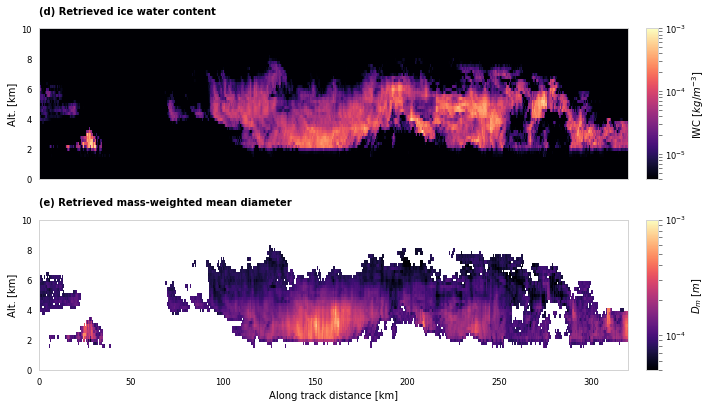

In [14]:
from matplotlib.colors import LogNorm, Normalize
from joint_flight.plots import grid_to_edges
from joint_flight.data import hamp
from joint_flight.data.in_situ import faam

f = plt.figure(figsize = (10, 8))
gs = GridSpec(3, 2, width_ratios = [1.0, 0.02])

x = hamp.d[:-1][mask]
y = np.linspace(0, 13, 66)
xx, yy = np.meshgrid(x, y)
xx = grid_to_edges(xx)
yy = grid_to_edges(yy)
norm = LogNorm(vmin = 4e-6, vmax = 1e-3)

#
# 
#

ax = plt.subplot(gs[0, 0])
ax.set_title("(d) Retrieved ice water content", loc = "left", fontweight = "bold")
img = ax.pcolormesh(xx, yy, md[mask, :].T , norm = norm)
plt.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "IWC [$kg/m^{-3}$]")
ax.set_xlim([0, 320])
ax.set_ylim([0, 10])
ax.set_xticks([])
ax.set_ylabel("Alt. [km]")

#
# D_m
#

dm_norm = LogNorm(vmin = 5e-5, vmax = 1e-3)
ax = plt.subplot(gs[1, 0])
ax.set_title("(e) Retrieved mass-weighted mean diameter", loc = "left", fontweight = "bold")
dm[md < 5e-6] = np.nan
img = ax.pcolormesh(xx, yy, dm[mask, :].T, norm = dm_norm)
plt.colorbar(img, cax = plt.subplot(gs[1, 1]), label = "$D_m$ [$m$]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
#ax.set_xticks([])
ax.set_ylabel("Alt. [km]")

##
## Relative humidity
##
#
#ax = plt.subplot(gs[2, 0])
#rh_norm = Normalize(vmin = 0, vmax = 100)
#rh = results["large_column_aggregate"]["rh"]
#ax.set_ylim([0, 10])
#ax.set_title("(c) Relative humidity ", loc = "left", fontweight = "bold")
#for d in faam.ds_d:
#    ax.axvline(d, c = "k", ls = "--")
#img = ax.pcolormesh(xx, yy, 100.0 * rh.T , norm = rh_norm)
#plt.colorbar(img, cax = plt.subplot(gs[2, 1]), label = "RH [%]")
#

ax.set_ylabel("Alt. [km]")
ax.set_xlabel("Along track distance [km]")

plt.tight_layout()
f.savefig("../plots/hmc.png", bbox_inches = "tight")

## LWC

## In-situ IWC

In [15]:
from joint_flight.data import hamp
from joint_flight.data.in_situ import faam
from scipy.interpolate import RegularGridInterpolator

from scipy.signal import convolve
k = np.ones(50) / 50.0

#
# Nevzorov probe data
#

nev_z   = np.convolve(faam.nev_z, k)
hmc_nev = np.convolve(faam.twc_ice / 1e3, k)
hmc_nev2 = np.convolve((faam.twc_ice / 1e3) ** 2, k) 
hmc_nev_sigma = np.sqrt(hmc_nev2 - hmc_nev ** 2)

#
# 8 Column aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_8ca = results["8_column_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_8ca)
hmc_8ca = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_8ca_ro = results["8_column_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_8ca_ro)
hmc_8ca_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

#
# Large plate aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_lpa = results["large_plate_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lpa)
hmc_lpa = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_lpa_ro = results["large_plate_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lpa_ro)
hmc_lpa_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

#
# Large column aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_lca = results["large_column_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lca)
hmc_lca = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_lca_ro = results["large_column_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lca_ro)
hmc_lca_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

## Only RADAR only

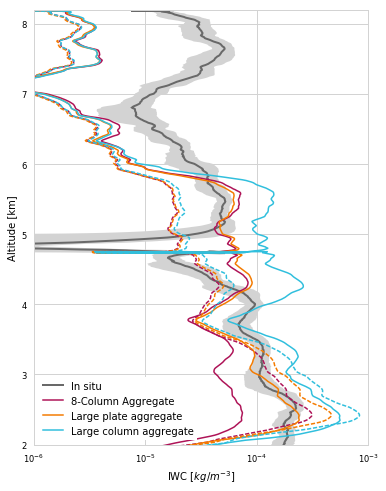

In [16]:
f, ax = plt.subplots(1, 1, figsize = (6, 8))
i_start = 100
i_end   = 1600

x_nev  = hmc_nev[i_start : i_end]
dx_nev = hmc_nev_sigma[i_start : i_end]
y = nev_z[i_start : i_end] / 1e3

ax.fill_betweenx(y, x_nev - dx_nev, x_nev + dx_nev, color = "lightgrey")
ax.plot(x_nev, y, c = "dimgrey", lw = 2, label = "In situ")

# 8-Column Aggregate
ax.plot(hmc_8ca[i_start : i_end], y, c = "C0", label = "8-Column Aggregate")
ax.plot(hmc_8ca_ro[i_start : i_end], y, ls = "--", c = "C0")

# Large plate aggregate
ax.plot(hmc_lpa[i_start : i_end], y, c = "C1", label = "Large plate aggregate")
ax.plot(hmc_lpa_ro[i_start : i_end], y, c = "C1", ls = "--")

# Large plate aggregate
ax.plot(hmc_lca[i_start : i_end], y, c = "C2", label = "Large column aggregate")
ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C2", ls = "--")

# Large column aggregate
#ax.plot(hmc_lca[i_start : i_end], y, c = "C1")
#ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C1", ls = "--")



ax.set_ylabel("Altitude [km]")

ax.legend()
ax.set_xlabel("IWC [$kg/m^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(1e-6, 1e-3)
ax.set_ylim(2, 8.2) 
f.savefig("../plots/iwc_in_situ.pdf", bbox_inches = "tight")

In [17]:
bins = np.logspace(-6, -3, 21)
img, _, _ = np.histogram2d(faam.twc_ice / 1e3, hmc_nev, bins =bins)
plt.pcolormesh(bins, bins, img)
plt.xscale("log")
plt.xlim([1e-6, 1e-3])
plt.yscale("log")
plt.ylim([1e-6, 1e-3])

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

## $D_m$

In [18]:
from joint_flight.data.in_situ import faam
from parts.scattering.psd.data.psd_data import PSDData, D_max
from parts.scattering.psd import D14MN
z = faam.psd_z
k = np.ones(40) / 40
z_avg = np.convolve(z / 1e3, k)

psd = PSDData(faam.psd_x, faam.psd_y.T, D_max(0.007, 2.2))
d14 = D14MN.from_psd_data(psd, 2.654, 0.750, 0.917)
dm_1  = d14.mass_weighted_diameter * 1e-2
dm_12 = np.convolve(dm_1 ** 2, k)
dm_1 = np.convolve(dm_1, k)
dm_1_sigma = np.sqrt(dm_12 - dm_1 ** 2)

psd = PSDData(faam.psd_x, faam.psd_y.T, D_max(0.016, 2.49))
d14 = D14MN.from_psd_data(psd, 2.654, 0.750, 0.917)
dm_2  = d14.mass_weighted_diameter * 1e-2
dm_2 = np.convolve(dm_2, k)

psd = PSDData(faam.psd_x, faam.psd_y.T, D_max(0.001, 1.69))
d14 = D14MN.from_psd_data(psd, 2.654, 0.750, 0.917)
dm_3 = d14.mass_weighted_diameter * 1e-2
dm_3 = np.convolve(dm_3, k)


/home/simon/build/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ARTS API from: /home/simon/build/arts/src/libarts_api.so


/home/simon/src/parts/parts/scattering/psd/d14.py:402: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simon/src/parts/parts/scattering/psd/d14.py:404: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4


In [19]:
z   = np.linspace(0, 13e3, 66)

k2 = np.ones((40, 1)) / 40

# 8 column aggregate
md = results["8_column_aggregate"]["ice_md"]
n0 = results["8_column_aggregate"]["ice_n0"]
c   = gamma(4.0) / 4
rho = 917.0
mask = np.all(np.logical_not(np.isnan(md)), axis = 1)
dm = (4 ** 4 / (6.0 * np.pi * rho) * md / n0) ** 0.25
dm = convolve(dm[mask, :], k2, mode = "same")
f = RegularGridInterpolator((hamp.d[:-1][mask], z), dm)
dm_8ca = f((faam.psd_d, faam.psd_z))
dm_8ca_avg = np.convolve(dm_8ca, k)

dm = (4 ** 4 / (6.0 * np.pi * rho) * md / 1e8) ** 0.25
f = RegularGridInterpolator((hamp.d[:-1], z), dm)
dm_8ca_a = f((faam.psd_d, faam.psd_z))
dm_8ca_a_avg = np.convolve(dm_8ca, k)

# large plate aggregate
md = results["large_plate_aggregate"]["ice_md"]
n0 = results["large_plate_aggregate"]["ice_n0"]
mask = np.all(np.logical_not(np.isnan(md)), axis = 1)
dm = (4 ** 4 / (6.0 * np.pi * rho) * md / n0) ** 0.25
f = RegularGridInterpolator((hamp.d[:-1], z), dm)
dm_lpa = f((faam.psd_d, faam.psd_z))
dm_lpa_avg = np.convolve(dm_lpa, k)

# large column aggregate
md = results["large_column_aggregate"]["ice_md"]
n0 = results["large_column_aggregate"]["ice_n0"]
#n0 = 1e8
mask = np.all(np.logical_not(np.isnan(md)), axis = 1)
dm = (4 ** 4 / (6.0 * np.pi * rho) * md / n0) ** 0.25
f = RegularGridInterpolator((hamp.d[:-1], z), dm)
dm_lca = f((faam.psd_d, faam.psd_z))
dm_lca_avg = np.convolve(dm_lca, k)

In [20]:
dm_8ca

array([9.44183157e-05, 9.44183157e-05, 9.44183157e-05, ...,
       1.72459288e-04, 1.72791270e-04, 1.73017935e-04])

In [21]:
i_start = 100
i_end   = 1600
plt.plot(dm_8ca_r[i_start : i_end], z_avg[i_start : i_end], c = "k", ls = "--")
plt.plot(dm_lca_r[i_start : i_end], z_avg[i_start : i_end], c = "k", ls = ":")
plt.plot(dm_lpa_r[i_start : i_end], z_avg[i_start : i_end], c = "k", ls = "-.")
plt.plot(dm_8ca_avg[i_start : i_end], z_avg[i_start : i_end], c = "C0")
plt.plot(dm_lca_avg[i_start : i_end], z_avg[i_start : i_end], c = "C1")
plt.plot(dm_lpa_avg[i_start : i_end], z_avg[i_start : i_end], c = "C2")
plt.xscale("log")

NameError: name 'dm_8ca_r' is not defined

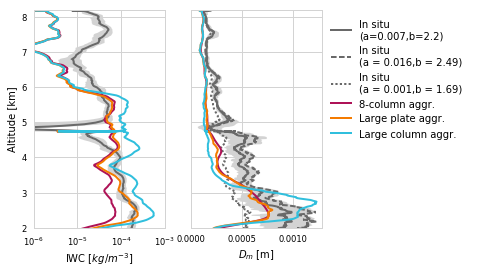

In [27]:
f, axs = plt.subplots(1, 3, figsize = (8, 4))
i_start = 100
i_end   = 1600

#
# IWC
#

x_nev  = hmc_nev[i_start : i_end]
dx_nev = hmc_nev_sigma[i_start : i_end]
y = nev_z[i_start : i_end] / 1e3

ax = axs[0]
ax.fill_betweenx(y, x_nev - dx_nev, x_nev + dx_nev, color = "lightgrey")
ax.plot(x_nev, y, c = "dimgrey", lw = 2, label = "In situ")

# 8-Column Aggregate
ax.plot(hmc_8ca[i_start : i_end], y, c = "C0", label = "8-Column Aggregate", lw = 2)
#ax.plot(hmc_8ca_ro[i_start : i_end], y, ls = "--", c = "C0")

# Large plate aggregate
ax.plot(hmc_lpa[i_start : i_end], y, c = "C1", label = "Large plate aggregate", lw = 2)
#ax.plot(hmc_lpa_ro[i_start : i_end], y, c = "C1", ls = "--")

# Large plate aggregate
ax.plot(hmc_lca[i_start : i_end], y, c = "C2", label = "Large column aggregate", lw = 2)
#ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C2", ls = "--")

# Large column aggregate
#ax.plot(hmc_lca[i_start : i_end], y, c = "C1")
#ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C1", ls = "--")


ax.set_xlabel("IWC [$kg/m^{-3}$]")
ax.set_xscale("log")
ax.set_ylabel("Altitude [km]")
ax.set_xlim(1e-6, 1e-3)
ax.set_ylim(2, 8.2) 

#
# D_m
#

ax = axs[1]

x  = dm_1[i_start : i_end]
dx = dm_1_sigma[i_start : i_end]
y  = z_avg[i_start : i_end]

handles = []
ax.fill_betweenx(y, x - dx, x + dx, color = "lightgrey")
handles += ax.plot(x, y, c = "dimgrey", lw = 2, label = "In situ\n(a=0.007,b=2.2)")
handles += ax.plot(dm_2[i_start : i_end], y, c = "dimgrey", lw = 2, label = "In situ\n(a = 0.016,b = 2.49)", ls = "--")
handles += ax.plot(dm_3[i_start : i_end], y, c = "dimgrey", lw = 2, label = "In situ\n(a = 0.001,b = 1.69)", ls = ":")
ax.set_yticklabels([])

# 8-Column Aggregate
handles += ax.plot(dm_8ca_avg[i_start : i_end], y, c = "C0", label = "8-column aggr.", lw = 2)
#
## Large plate aggregate
#ax.plot(hmc_lpa[i_start : i_end], y, c = "C1", label = "Large plate aggregate")
#ax.plot(hmc_lpa_ro[i_start : i_end], y, c = "C1", ls = "--")
handles += ax.plot(dm_lpa_avg[i_start : i_end], y, c = "C1", label = "Large plate aggr.", lw = 2)
#
## Large plate aggregate
#ax.plot(hmc_lca[i_start : i_end], y, c = "C2", label = "Large column aggregate")
#ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C2", ls = "--")
handles += ax.plot(dm_lca_avg[i_start : i_end], y, c = "C2", label = "Large column aggr.", lw = 2)
#ax.set_xscale("log")
#
ax.set_xlabel("$D_m$ [m]")
ax.set_ylim(2, 8.2) 
## Large column aggregate
##ax.plot(hmc_lca[i_start : i_end], y, c = "C1")
##ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C1", ls = "--")

ax = axs[2]

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for s in ax.spines:
    ax.spines[s].set_visible(False)
ax.legend(handles = handles, loc = "upper left", bbox_to_anchor = [-0.2, 1.0])
f.savefig("../plots/iwc_in_situ.pdf", bbox_inches = "tight")

In [23]:
dm_8ca

array([9.44183157e-05, 9.44183157e-05, 9.44183157e-05, ...,
       1.72459288e-04, 1.72791270e-04, 1.73017935e-04])

In [ ]:

#
# Nevzorov probe data
#

z_cip   = np.convolve(faam.z_cip, k)
dm_cip  = np.convolve(dm, k)
dm_cip2 = np.convolve((faam.twc_ice / 1e3) ** 2, k) 
dm_cip_sigma = np.sqrt(dm_cip2 - dm_cip ** 2)

#
# 8 Column aggregate
#

z   = np.linspace(0, 13e3, 66)
hmc_8ca = results["8_column_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_8ca)
hmc_8ca = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_8ca_ro = results["8_column_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_8ca_ro)
hmc_8ca_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

#
# Large plate aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_lpa = results["large_plate_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lpa)
hmc_lpa = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_lpa_ro = results["large_plate_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lpa_ro)
hmc_lpa_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

#
# Large column aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_lca = results["large_column_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lca)
hmc_lca = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_lca_ro = results["large_column_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lca_ro)
hmc_lca_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

In [ ]:
i_start = 100
i_end   = 1600

x_nev  = hmc_nev[i_start : i_end]
dx_nev = hmc_nev_sigma[i_start : i_end]
y = nev_z[i_start : i_end] / 1e3

ax.fill_betweenx(y, x_nev - dx_nev, x_nev + dx_nev, color = "silver")
ax.plot(x_nev, y, c = "dimgrey", lw = 2, label = "In situ")

# 8-Column Aggregate
ax.plot(hmc_8ca[i_start : i_end], y, c = "C0", label = "8-Column Aggregate")
ax.plot(hmc_8ca_ro[i_start : i_end], y, ls = "--", c = "C0")

# Large plate aggregate
ax.plot(hmc_lpa[i_start : i_end], y, c = "C1", label = "Large plate aggregate")
ax.plot(hmc_lpa_ro[i_start : i_end], y, c = "C1", ls = "--")

# Large plate aggregate
ax.plot(hmc_lca[i_start : i_end], y, c = "C2", label = "Large column aggregate")
ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C2", ls = "--")

# Large column aggregate
#ax.plot(hmc_lca[i_start : i_end], y, c = "C1")
#ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C1", ls = "--")



ax.set_ylabel("Altitude [km]")

ax.legend()
ax.set_xlabel("IWC [$kg/m^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(1e-6, 1e-3)
ax.set_ylim(2, 8.2) 
f.savefig("../plots/iwc_in_situ.pdf", bbox_inches = "tight")

## In-situ RH

In [21]:
from joint_flight.data.in_situ import faam
from joint_flight.data import era5

faam.ds_d
rh_inds = [np.argmin(np.abs(hamp.d - d)) for d in faam.ds_d]

In [22]:
faam.ds_d

[13.181170274373713, 121.2507738086377, 236.2003521113417, 320.6613386257547]

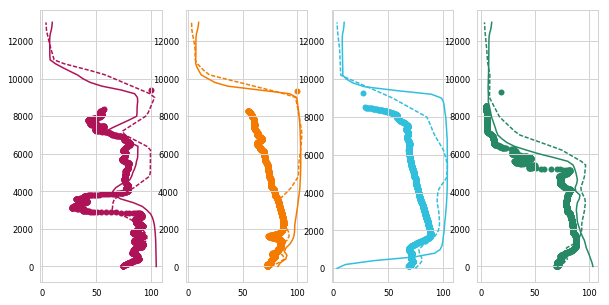

In [23]:
f, axs = plt.subplots(1, 4, figsize = (10, 5))
for i, j in enumerate(rh_inds):
    ax = axs[i]
    ax.plot(results["8_column_aggregate"]["rh"][j, :] * 100, z, c = "C" + str(i))
    ax.plot(era5.rh[j, :], z, c = "C" + str(i), ls = "--")
    ax.scatter(faam.ds_rh[i], faam.ds_z[i], c = "C" + str(i))

In [25]:
from typhon.physics import e_eq_ice_mk, e_eq_water_mk

/home/simon/build/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [26]:
for i, j in enumerate(rh_inds):
    print(i, j)

0 57
1 532
2 1037
3 1411
